In [2]:
import numpy as np
import math
import itertools
from typing import Iterable, Iterator, Tuple, TypeVar, Dict
from dataclasses import dataclass
import matplotlib.pyplot as plt
from scipy.stats import norm
import timeit
from scipy.optimize import brentq
from scipy.optimize import newton

In [41]:
@dataclass(frozen=True)
class MC_pricing():
    F0:float
    T:float
    alpha0:float
    beta:float
    nu:float
    rho:float
    Nstep:int
    K: float

    def simulate_trace(self)->Iterable[float]:
        F1 = self.F0
        F2 = self.F0
        alpha1 = self.alpha0
        alpha2 = self.alpha0
        t = 0
        count = 0
        dt_list = np.flip(np.diff(np.geomspace(1e-5, self.T, num=self.Nstep),prepend=[0]))
        while count< len(dt_list):
            dt = dt_list[count]
            count += 1
            X1 = np.random.randn()
            X2 = np.random.randn()

            F1 += alpha1*pow(F1,self.beta)*np.sqrt(dt)*X1
            alpha1 += self.nu*alpha1*np.sqrt(dt)*(np.sqrt(1-self.rho**2)*X2 + self.rho*X1)
            F2 += alpha2*pow(F1,self.beta)*np.sqrt(dt)*(-1*X1)
            alpha2 += self.nu*alpha2*np.sqrt(dt)*(np.sqrt(1-self.rho**2)*(-1*X2) + self.rho*(-1*X1))

            yield (F1,F2)

    def get_payoff(self)->Iterable[Tuple[float,float]]:

        while True:

            trace = self.simulate_trace()
            *_, (Ffinal1,Ffinal2) = trace
            payoff1 = np.maximum(Ffinal1 - self.K,0)
            payoff2 = np.maximum(Ffinal2 - self.K,0)



        #    count += 1
        #    delta = payoff1 - mean
        #    mean += delta/count
        #    delta2 = payoff1 - mean
        #    M2 += delta*delta2
#
        #    count += 1
        #    delta = payoff2 - mean
        #    mean += delta/count
        #    delta2 = payoff2 - mean
        #    M2 += delta*delta2

            yield (payoff1+payoff2)/2
    def bs_call(self,vol:float)->float:
        d1 = (np.log(self.F0/self.K) + (0.5*vol**2)*self.T) / (vol*np.sqrt(self.T))
        d2 = d1 - vol * np.sqrt(self.T)
        return self.F0 * norm.cdf(d1) -  self.K * norm.cdf(d2)

    def bs_vega(self,vol:float):
        d1 = (np.log(self.F0 / self.K) + (0.5 * vol ** 2) * self.T) / (vol* np.sqrt(self.T))
        return self.F0 * norm.pdf(d1) * np.sqrt(self.T)

    def im_vol(self,target_price:float,PRECISION:float = 1.0e-5)->float:
        MAX_ITERATIONS = 10000
        sig_u, sig_d = 2, 0.1
        sig = 0.9
        price = self.bs_call(sig)
        err = target_price - price
        count = 0
        while abs(err)> PRECISION and count < MAX_ITERATIONS:
            if err > 0:
                sig_d = sig
                sig = (sig_u + sig_d)/2
            else:
                sig_u = sig
                sig = (sig_d + sig_u)/2
            price = self.bs_call(sig)
            err = target_price - price
            count += 1
        return sig # value wasn't found, return best guess so far

C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


The expected value is 21.708156719099186
The implied vol is0.38964118957519533


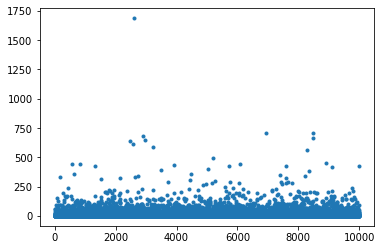

In [4]:
start = timeit.default_timer()
#m1 = MC_pricing(F0=1.,T = 2.0, alpha0=0.35,beta=0.25,nu=1.0,rho=0.25,Nstep = 1000,K=1.)
m1 = MC_pricing(F0=100.,T = 2.0, alpha0=11,beta=0.25,nu=1.0,rho=0.25,Nstep = 1000,K=100.)
payoffs = m1.get_payoff()
niter = 10000
payoffs = list(itertools.islice(payoffs,niter))
plt.plot(payoffs,'.')
payoffs=np.array(payoffs)
payoffs = payoffs[np.isfinite(payoffs)]
stop = timeit.default_timer()

value  = np.mean(payoffs)
vol = m1.im_vol(value)
print("The expected value is " +str(np.mean(payoffs)))
print("The implied vol is " + str(vol))
print('Time: ', stop - start)

K = 0.1
Time:  45.442142900000135
K = 0.3
Time:  44.80711770000016
K = 0.5
Time:  45.1194837999999
K = 0.7
Time:  44.48863069999993
K = 0.8999999999999999
Time:  44.42560669999989
K = 1.0999999999999999
Time:  45.39880220000009
K = 1.3
Time:  45.34776190000002
K = 1.5
Time:  45.76566290000005
K = 1.7
Time:  45.83060670000009
K = 1.9
Time:  46.120518400000265


C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0, 'K')

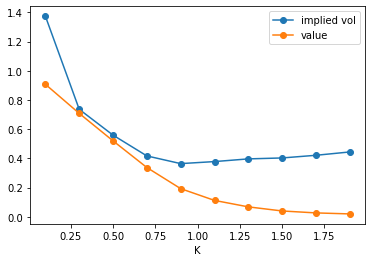

In [12]:
Klist = np.linspace(0.2,1.9,9)
vol_list = []
val_list = []
for K in Klist:
    print("K = "+str(K))
    start = timeit.default_timer()
    m1 = MC_pricing(F0=1.0,T = 1.0, alpha0=0.35,beta=0.25,nu=1.0,rho=0.25,Nstep = 1000,K=K)
    payoffs = m1.get_payoff()
    niter = 5000
    payoffs = list(itertools.islice(payoffs,niter))
    payoffs=np.array(payoffs)
    payoffs = payoffs[np.isfinite(payoffs)]

    value = np.mean(payoffs)
    vol = m1.im_vol(value)
    vol_list.append(vol)
    val_list.append(value)
    stop = timeit.default_timer()

    print('Time: ', stop - start)

plt.plot(Klist,vol_list,'-o',label = 'implied vol')
plt.plot(Klist,val_list,'-o',label = 'value')
plt.legend()
plt.xlabel('K')



K = 0.2
Time:  46.895454599999994
K = 0.4
Time:  45.702704899999844
K = 0.6000000000000001
Time:  47.23918720000029
K = 0.8
Time:  45.503750500000024
K = 1.0
Time:  46.13053149999996
K = 1.2
Time:  46.33875410000019
K = 1.4000000000000001
Time:  47.97274110000035
K = 1.6
Time:  45.54564409999966
K = 1.8
Time:  45.746348200000284
K = 0.2
Time:  46.73973110000043
K = 0.4
Time:  46.01901010000074
K = 0.6000000000000001
Time:  46.28822080000009
K = 0.8
Time:  46.40257840000049
K = 1.0
Time:  45.94019710000066
K = 1.2
Time:  44.801438400000734
K = 1.4000000000000001
Time:  44.32919940000011
K = 1.6
Time:  44.09448640000028
K = 1.8
Time:  44.13976309999998
K = 0.2
Time:  44.42132690000017
K = 0.4
Time:  44.40543319999961
K = 0.6000000000000001
Time:  44.3670276999992
K = 0.8
Time:  44.36090469999999
K = 1.0
Time:  44.52457359999971
K = 1.2
Time:  44.5262616
K = 1.4000000000000001
Time:  45.67749019999974
K = 1.6
Time:  47.29299960000026
K = 1.8
Time:  47.15632800000003
K = 0.2
Time:  47.9945

C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid valu

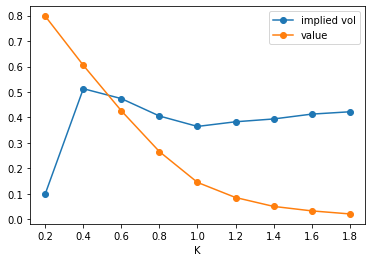

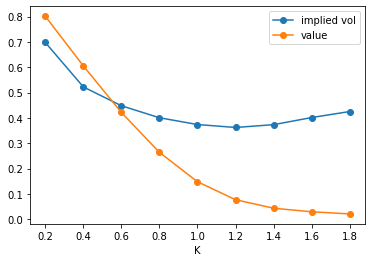

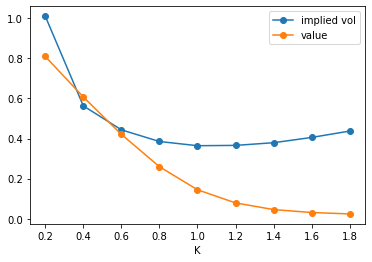

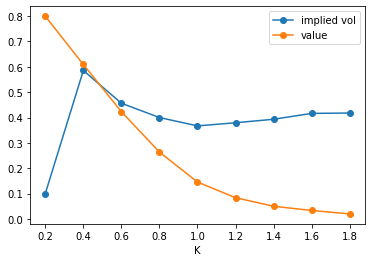

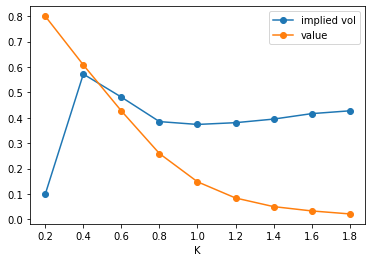

In [16]:
vol_record = []
val_record = []
for count in range(5):
    Klist = np.linspace(0.6,1.4,9)
    vol_list = []
    val_list = []
    for K in Klist:
        print("K = "+str(K))
        start = timeit.default_timer()
        m1 = MC_pricing(F0=1.0,T = 1.0, alpha0=0.35,beta=0.25,nu=1.0,rho=0.25,Nstep = 1000,K=K)
        payoffs = m1.get_payoff()
        niter = 5000
        payoffs = list(itertools.islice(payoffs,niter))
        payoffs=np.array(payoffs)
        payoffs = payoffs[np.isfinite(payoffs)]

        value = np.mean(payoffs)
        vol = m1.im_vol(value)
        vol_list.append(vol)
        val_list.append(value)
        stop = timeit.default_timer()

        print('Time: ', stop - start)

    plt.figure()
    plt.plot(Klist,vol_list,'-o',label = 'implied vol')
    plt.plot(Klist,val_list,'-o',label = 'value')
    plt.legend()
    plt.xlabel('K')

    vol_record.append(vol_list)
    val_record.append(val_list)

K = 0.6
Time:  52.37223710000035
K = 0.7
Time:  52.1553143000001
K = 0.7999999999999999
Time:  53.77642990000095
K = 0.8999999999999999
Time:  52.567962900000566
K = 1.0
Time:  51.29688150000038
K = 1.0999999999999999
Time:  51.65163659999962
K = 1.2
Time:  51.604746400000295
K = 1.2999999999999998
Time:  52.42238720000023
K = 1.4
Time:  53.23289250000016
K = 0.6
Time:  53.79028269999981
K = 0.7
Time:  52.979744299998856
K = 0.7999999999999999
Time:  53.40175479999925
K = 0.8999999999999999
Time:  52.60161089999929
K = 1.0
Time:  53.97590010000022
K = 1.0999999999999999
Time:  53.56504930000119
K = 1.2
Time:  52.19284699999844
K = 1.2999999999999998
Time:  51.116647299999386
K = 1.4
Time:  50.93907059999947
K = 0.6
Time:  49.24714949999907
K = 0.7
Time:  48.96382219999941
K = 0.7999999999999999
Time:  49.07910609999999
K = 0.8999999999999999
Time:  48.999452299998666
K = 1.0
Time:  49.861835200001224
K = 1.0999999999999999
Time:  49.54703879999943
K = 1.2
Time:  49.682051599998886
K = 

C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid valu

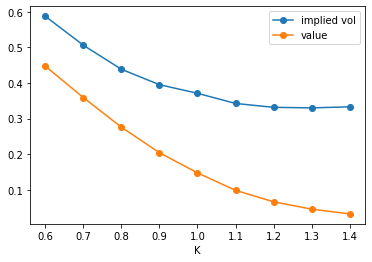

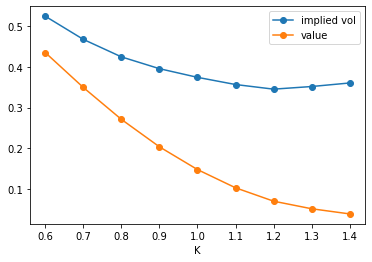

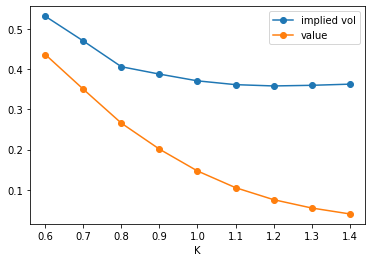

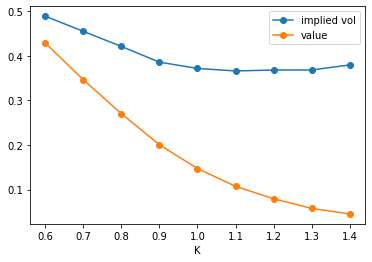

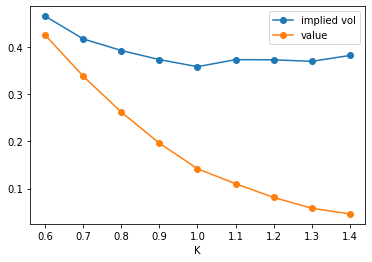

In [68]:
vol_record2 = []
val_record2 = []
for rho in np.linspace(-0.25,0.25,5):
    Klist = np.linspace(0.6,1.8,9)
    vol_list = []
    val_list = []
    for K in Klist:
        print("K = "+str(K))
        start = timeit.default_timer()
        m1 = MC_pricing(F0=1.0,T = 1.0, alpha0=0.35,beta=0.25,nu=1.0,rho=rho,Nstep = 1000,K=K)
        payoffs = m1.get_payoff()
        niter = 5000
        payoffs = list(itertools.islice(payoffs,niter))
        payoffs=np.array(payoffs)
        payoffs = payoffs[np.isfinite(payoffs)]

        value = np.mean(payoffs)
        vol = m1.im_vol(value)
        vol_list.append(vol)
        val_list.append(value)
        stop = timeit.default_timer()

        print('Time: ', stop - start)

    plt.figure()
    plt.plot(Klist,vol_list,'-o',label = 'implied vol')
    plt.plot(Klist,val_list,'-o',label = 'value')
    plt.legend()
    plt.xlabel('K')

    vol_record2.append(vol_list)
    val_record2.append(val_list)

## T dynamics

K = 0.5
Time:  52.93073169999843
K = 0.6625
Time:  51.409130100000766
K = 0.825
Time:  50.69502339999963
K = 0.9875
Time:  50.96095360000072
K = 1.15
Time:  50.7350136999994
K = 1.3125
Time:  51.505332999999155
K = 1.475
Time:  52.86337409999942
K = 1.6375
Time:  52.71982500000013
K = 1.8
Time:  53.35072410000066
K = 0.5
Time:  53.48699559999841
K = 0.6625
Time:  53.77762090000033
K = 0.825
Time:  53.4909803999999
K = 0.9875
Time:  53.527066900000136
K = 1.15
Time:  53.226448000001255
K = 1.3125
Time:  52.36505770000076
K = 1.475
Time:  52.79445789999954
K = 1.6375
Time:  52.437573899998824
K = 1.8
Time:  51.687164299999495
K = 0.5
Time:  52.32337600000028
K = 0.6625
Time:  52.126469500000894
K = 0.825
Time:  51.77761780000037
K = 0.9875
Time:  52.14074190000065
K = 1.15
Time:  52.30170139999973
K = 1.3125
Time:  52.40064169999823
K = 1.475
Time:  51.71446069999911
K = 1.6375
Time:  52.35092689999874
K = 1.8
Time:  52.34770369999933
K = 0.5
Time:  52.4039171000004
K = 0.6625
Time:  52.

C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\yingb\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


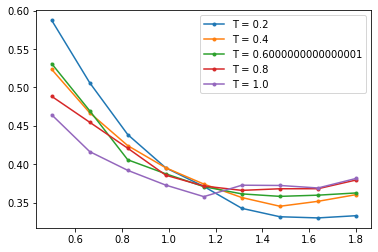

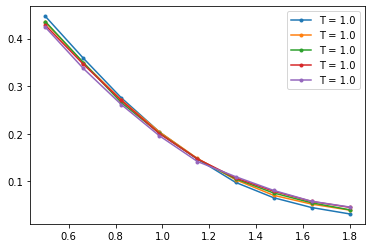

In [76]:
Tlist = np.linspace(0.2,1,5)
Klist = np.linspace(0.5,1.8,9)
vol_record3 = []
val_record3 = []
for T in Tlist:
    vol_list = []
    val_list = []
    for K in Klist:
        print("K = "+str(K))
        start = timeit.default_timer()
        m1 = MC_pricing(F0=1.0,T = 1.0, alpha0=0.35,beta=0.25,nu=1.0,rho=rho,Nstep = 1000,K=K)
        payoffs = m1.get_payoff()
        niter = 5000
        payoffs = list(itertools.islice(payoffs,niter))
        payoffs=np.array(payoffs)
        payoffs = payoffs[np.isfinite(payoffs)]

        value = np.mean(payoffs)
        vol = m1.im_vol(value)
        vol_list.append(vol)
        val_list.append(value)
        stop = timeit.default_timer()

        print('Time: ', stop - start)

    vol_record3.append(vol_list)
    val_record3.append(val_list)

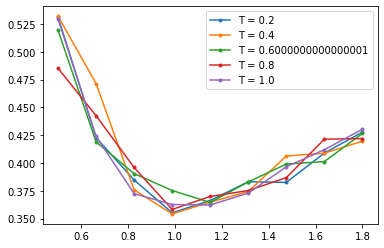

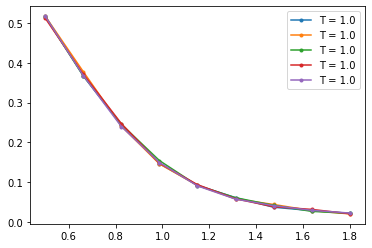

In [78]:
# make plots
plt.figure()
count = 0
for vol in vol_record3:
    T = Tlist[count]
    count += 1
    plt.plot(Klist,vol,'.-',label = "T = "+str(T))

plt.legend()

plt.figure()
count = 0
for val in val_record3:
    rho = Tlist[count]
    count += 1
    plt.plot(Klist,val,'.-',label = "T = "+str(T))

plt.legend()

## Test Code Below

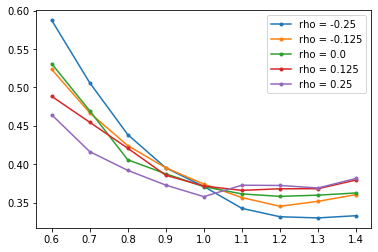

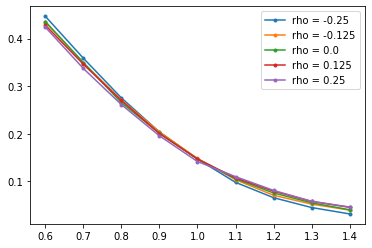

In [73]:
rho_list = np.linspace(-0.25,0.25,5)
count = 0
for vol in vol_record2:
    rho = rho_list[count]
    count += 1
    plt.plot(Klist,vol,'.-',label = "rho = "+str(rho))

plt.legend()

plt.figure()
count = 0
for val in val_record2:
    rho = rho_list[count]
    count += 1
    plt.plot(Klist,val,'.-',label = "rho = "+str(rho))

plt.legend()

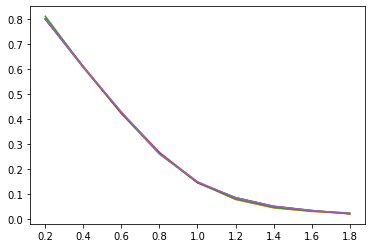

In [19]:
for val in val_record:
    plt.plot(Klist[2:],val[2:],)

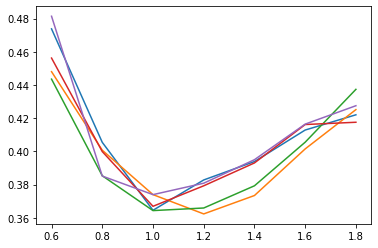

In [59]:
for vol in vol_record:
    plt.plot(Klist[2:],vol[2:])

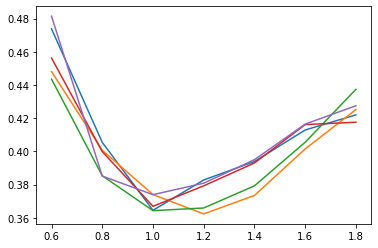

In [58]:
Klist=np.linspace(0.2,1.8,9)
for val in val_record:
    vol_test = []
    count = 0
    for v in val:
        K = Klist[count]
        m2 = MC_pricing(F0=1.0,T = 1.0, alpha0=0.35,beta=0.25,nu=1.0,rho=0.25,Nstep = 1000,K=K)
        vol_test.append(m2.im_vol(v,PRECISION = 1e-9))
        count += 1
    plt.plot(Klist[2:],vol_test[2:])

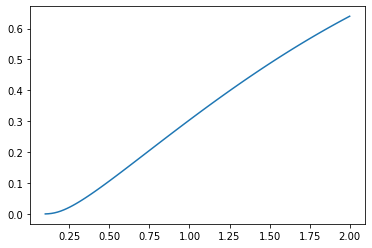

In [67]:
def bs_call(vol:float,F0:float,T:float, r:float, K: float)->float:
        d1 = (np.log(F0/K) + (r+0.5*vol**2)*T) / (vol*np.sqrt(T))
        d2 = d1 - vol * np.sqrt(T)
        return F0 * norm.cdf(d1) -  K * np.exp(-r*T)*norm.cdf(d2)
V =[]

for vol in np.linspace(0.1,2,100):
    V.append(bs_call(F0=1.0,T = 1.0, r = 0, K = 1.3,vol=vol))

plt.plot(np.linspace(0.1,2,100),V)